In [2]:
import os
import sys
import torch
import torch.backends.cudnn as cudnn
from os import path, mkdir
import logging
from torch.utils.tensorboard import SummaryWriter

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from feature_extractor import FeaturesWriter, get_features_loader
from utils.utils import register_logger
from utils.load_model import load_feature_extractor
from features_loader import FeaturesLoader
from network.TorchUtils import TorchModel
from network.anomaly_detector_model import AnomalyDetector, custom_objective, RegularizedLoss
from utils.callbacks import DefaultModelCallback, TensorBoardCallback

In [2]:
from langchain_community.llms import Ollama
llm = Ollama(model="llama2")

In [3]:
log_every = 50  # log the writing of clips every n steps
log_file = None  # set logging file
num_workers = 4  # define the number of workers used for loading the videos

cudnn.benchmark = True
register_logger(log_file=log_file)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

dataset_path = '/home/ubuntu/repos/llm-rag/data/Anomaly-Videos-Part-1/test'  # path to the video dataset
clip_length = 16  # define the length of each input sample
frame_interval = 1 # define the sampling interval between framesq
batch_size = 4


In [4]:
llm.invoke("how are you doing today?")

'I\'m just an AI, I don\'t have feelings or emotions, so I can\'t say that I\'m "doing well" in the way that a human might. However, I\'m here and ready to help you with any questions or tasks you may have! Is there anything specific you\'d like me to assist you with today?'

In [4]:
import clip
import numpy as np
from lavis.models import load_model_and_preprocess
from torchvision.transforms import ToPILImage
import chromadb
from chromadb.utils.embedding_functions import OpenCLIPEmbeddingFunction
from chromadb.utils.data_loaders import ImageLoader

class ClipEncoder:
    def __init__(self, dataset_path, clip_length, caption_model_type, frame_interval, batch_size, num_workers):
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.dataset_path = dataset_path
        self.clip_length = clip_length
        self.frame_interval = frame_interval
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.chroma_client = chromadb.HttpClient(host='localhost', port=8000)
        self.data_loader, self.data_iter = get_features_loader(dataset_path,
                                                                    clip_length,
                                                                    frame_interval,
                                                                    batch_size,
                                                                    num_workers,
                                                                    "clip"
                                                                    )
        self.model, self.preprocess = clip.load("ViT-B/32", device=device)
        self.caption_model, self.vis_processors, _ = load_model_and_preprocess(name="blip_caption",
                                                                               model_type=caption_model_type,
                                                                               is_eval=True,
                                                                               device=device)
    def encode_image(self, idx):
        frame_tensor = self.data_loader[idx][0].permute(1, 0, 2, 3)
        with torch.no_grad():
            frame_embeddings = self.model.encode_image(frame_tensor.cuda())
        return frame_embeddings

    def get_all_image_embeddings(self):
        embeddings = []
        for idx in range(len(self.data_loader)):
            emb = self.encode_image(idx)
            embeddings.append(emb)
        return embeddings
    
    def export_tensor_to_np(self):
        arr = []
        for idx in range(len(self.data_loader)):
            frame_tensor = self.data_loader[idx][0].permute(1, 0, 2, 3)
            pil_image = ToPILImage()(frame_tensor[0]) 
            arr.append(np.array(pil_image))
        return arr
    
    def get_captions(self):
        captions_list = []  
        for idx in range(len(self.data_loader)):  
            frame_tensor = self.data_loader[idx][0].permute(1, 0, 2, 3)
            pil_image = ToPILImage()(frame_tensor[0]) 
            image = self.vis_processors["eval"](pil_image).unsqueeze(0).to(self.device)
            generated_captions = self.caption_model.generate({"image": image})  
            captions_list.append(generated_captions)
        return captions_list

    def get_all_caption_embeddings(self, captions_list):
        # Future improvements: Maybe multiple captions per image; Think about a way how to add anomalous captions / features
        caption_embeddings = []
        if captions_list:
            for caption_set in captions_list:
                if caption_set:
                    for caption in caption_set:
                        if caption and len(caption) > 0:
                            with torch.no_grad():
                                try:
                                    caption_features = clip.tokenize(caption).to(self.device)
                                    caption_embedding = self.model.encode_text(caption_features)
                                    caption_embeddings.append(caption_embedding)
                                except Exception as e:
                                    print(f"Error encoding text for caption: {caption}")
                                    print(f"Error details: {e}")
        return caption_embeddings
    
    def get_or_create_chroma_collection(self, collection_name, embedding_function=None, data_loader=None):
        if embedding_function:
            try:
                collection = self.chroma_client.get_or_create_collection(name=collection_name, embedding_function=embedding_function, data_loader=data_loader)
                return collection
            except Exception as e:
                print(f"Error creating collection: {collection_name}")
                print(f"Error details: {e}")
        else:    
            try:
                collection = self.chroma_client.get_or_create_collection(collection_name)
                return collection
            except Exception as e:
                print(f"Error creating collection: {collection_name}")
                print(f"Error details: {e}")


    def upload_embeddings_to_chroma(self, collection_name, img_data, ids, multi_modal= False, captions=None, documents=None, metadata=None):
        if multi_modal:
            if not len(img_data) == len(ids):
                raise ValueError("data and ids must have the same length")
            
            embedding_function = OpenCLIPEmbeddingFunction("ViT-H-14","laion2b_s32b_b79k" )
            data_loader = ImageLoader()
            
            collection = self.get_or_create_chroma_collection(collection_name, embedding_function, data_loader)
            print("Multi Modal Collection created")

            for frame, id_ in zip(img_data, ids):
                try:
                    collection.add(images=frame[0], metadatas=metadata, ids=id_[0])
                    
                except Exception as e:
                    print(f"Failed to add document with ID {id_}: {str(e)}")         
        
        else:
            if not len(img_data) == len(ids):
                raise ValueError("data and ids must have the same length")

            collection = self.get_or_create_chroma_collection(collection_name)

            for emb, id_ in zip(img_data, ids):
                try:
                    collection.add(documents=documents, embeddings=emb, metadatas=metadata, ids=id_)
                except Exception as e:
                    print(f"Failed to add document with ID {id_}: {str(e)}")                
            

In [5]:
query_video = "/home/ubuntu/repos/llm-rag/data/query"
encoder = ClipEncoder(query_video, clip_length, 'base_coco', frame_interval, batch_size, num_workers)

np_arr = encoder.export_tensor_to_np()


2024-04-03 13:35:58,402 Anonymized telemetry enabled. See                     https://docs.trychroma.com/telemetry for more information.
2024-04-03 13:35:58,439 Anonymized telemetry enabled. See                     https://docs.trychroma.com/telemetry for more information.
2024-04-03 13:35:58,481 Found 1 video files in /home/ubuntu/repos/llm-rag/data/query


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


2024-04-03 13:36:29,168 Missing keys []
2024-04-03 13:36:29,169 load checkpoint from https://storage.googleapis.com/sfr-vision-language-research/LAVIS/models/BLIP/blip_coco_caption_base.pth


/home/ubuntu/anaconda3/envs/anomaly_310/lib/python3.10/site-packages/torchvision/io/video.py:161: UserWarning: The pts_unit 'pts' gives wrong results. Please use pts_unit 'sec'.
  warnings.warn("The pts_unit 'pts' gives wrong results. Please use pts_unit 'sec'.")


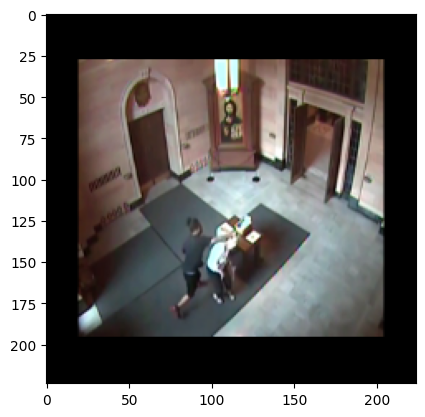

In [11]:
import matplotlib.pyplot as plt

img = np_arr[19]
plt.imshow(img)


#frame_embeddings = encoder.model.encode_image(frame_tensor.cuda())
#query_vec = frame_embeddings[0].tolist()

In [13]:
# First chroma retriever
from langchain_community.vectorstores import Chroma
from langchain_experimental.open_clip import OpenCLIPEmbeddings
from langchain.chains import VectorDBQA

db = Chroma(collection_name='multi-modal-norm', persist_directory='/home/ubuntu/chroma_db/', embedding_function=OpenCLIPEmbeddings())




2024-03-28 19:10:45,065 Loaded ViT-H-14 model config.
2024-03-28 19:10:54,648 Loading pretrained ViT-H-14 weights (laion2b_s32b_b79k).
2024-03-28 19:10:57,193 Anonymized telemetry enabled. See                     https://docs.trychroma.com/telemetry for more information.


In [14]:
print(img)

[[[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [164 166 151]
  [152 153 139]
  [109 110  98]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [165 167 152]
  [152 153 139]
  [110 111  99]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [166 168 153]
  [152 153 139]
  [111 112 100]]

 ...

 [[149  79  17]
  [159  82   6]
  [166  86   0]
  ...
  [255 245 168]
  [255 248 178]
  [255 254 209]]

 [[161  90  34]
  [166  91  15]
  [170  92   3]
  ...
  [255 247 167]
  [255 250 180]
  [255 254 213]]

 [[173 102  47]
  [176 101  24]
  [177 100  11]
  ...
  [255 249 169]
  [255 252 183]
  [255 255 214]]]


In [ ]:
retriever = db.as_retriever()

docs = retriever.get_relevant_documents("2 people sitting")

